In [ ]:
# Import all required libraries
import warnings
import pathlib

# Data manipulation and scientific computing
import pandas as pd
import numpy as np
import scipy.sparse

# Machine learning and neural networks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, average_precision_score,
    classification_report, confusion_matrix, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Progress bars and utilities
from tqdm import tqdm

# Domain-specific libraries
import hetmatpy.matrix

Repository directory: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/dwpc_rnn
Data directory: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/dwpc_rnn/data
Permutations directory: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/dwpc_rnn/data/permutations
Available permutations: ['000.hetmat', '000.hetmat.bak', '001.hetmat']


In [ ]:
# Parameters for papermill
# Default parameter values - can be overridden by papermill
permutations_subdirectory = "permutations"  # Default: use 'permutations' (local generated)
                                           # Example alternatives: 'hetio200' (downloaded), 'permutations/hetio200'

# Validation
if not isinstance(permutations_subdirectory, str):
    raise ValueError(f"permutations_subdirectory must be a string, got: {permutations_subdirectory}")

print(f"Using permutations subdirectory: {permutations_subdirectory}")

In [ ]:
# Set up paths for data access using parameterized directory
repo_dir = pathlib.Path().cwd().parent
data_dir = repo_dir / 'data'

# Use the parameterized permutations subdirectory
if '/' in permutations_subdirectory:
    # Handle nested paths like 'permutations/hetio200'
    permutations_dir = data_dir / permutations_subdirectory
else:
    # Handle simple paths like 'permutations' or 'hetio200'
    permutations_dir = data_dir / 'permutations' / permutations_subdirectory

print(f"Repository directory: {repo_dir}")
print(f"Data directory: {data_dir}")
print(f"Permutations directory: {permutations_dir}")

# List available permutations
if permutations_dir.exists():
    available_permutations = [p.name for p in permutations_dir.iterdir() if p.is_dir()]
    print(f"Available permutations: {available_permutations}")
else:
    print(f"⚠️ Permutations directory not found: {permutations_dir}")
    available_permutations = []

In [33]:
def load_permutation_data(permutation_name):
    """
    Load AeG edges, Anatomy nodes, and Gene nodes for a specific permutation.
    
    Parameters:
    -----------
    permutation_name : str
        Name of the permutation directory (e.g., '001.hetmat')
    
    Returns:
    --------
    dict : Dictionary containing loaded data with keys:
           - 'aeg_edges': scipy sparse matrix for AeG edges
           - 'anatomy_nodes': pandas DataFrame of anatomy nodes
           - 'gene_nodes': pandas DataFrame of gene nodes
           - 'permutation_path': pathlib.Path to the permutation directory
    """
    # Set up paths for this permutation
    perm_dir = permutations_dir / permutation_name
    edges_dir = perm_dir / 'edges'
    nodes_dir = perm_dir / 'nodes'
    
    if not perm_dir.exists():
        raise FileNotFoundError(f"Permutation directory not found: {perm_dir}")
    
    print(f"Loading data from permutation: {permutation_name}")
    print(f"Permutation path: {perm_dir}")
    
    # Load AeG edges (Anatomy-expresses-Gene)
    aeg_path = edges_dir / 'AeG.sparse.npz'
    if not aeg_path.exists():
        raise FileNotFoundError(f"AeG edges file not found: {aeg_path}")
    
    aeg_edges = scipy.sparse.load_npz(aeg_path)
    print(f"Loaded AeG edges: {aeg_edges.shape} matrix with {aeg_edges.nnz} non-zero entries")
    
    # Load Anatomy nodes
    anatomy_path = nodes_dir / 'Anatomy.tsv'
    if not anatomy_path.exists():
        raise FileNotFoundError(f"Anatomy nodes file not found: {anatomy_path}")
    
    anatomy_nodes = pd.read_csv(anatomy_path, sep='\t')
    print(f"Loaded Anatomy nodes: {len(anatomy_nodes)} nodes")
    print(f"Anatomy columns: {list(anatomy_nodes.columns)}")
    
    # Load Gene nodes
    gene_path = nodes_dir / 'Gene.tsv'
    if not gene_path.exists():
        raise FileNotFoundError(f"Gene nodes file not found: {gene_path}")
    
    gene_nodes = pd.read_csv(gene_path, sep='\t')
    print(f"Loaded Gene nodes: {len(gene_nodes)} nodes")
    print(f"Gene columns: {list(gene_nodes.columns)}")
    
    return {
        'aeg_edges': aeg_edges,
        'anatomy_nodes': anatomy_nodes,
        'gene_nodes': gene_nodes,
        'permutation_path': perm_dir
    }

In [34]:
# Load data from the first available permutation
if available_permutations:
    # Use the first permutation as an example
    example_permutation = available_permutations[0]
    print(f"Loading example data from: {example_permutation}")
    
    # Load the data
    perm_data = load_permutation_data(example_permutation)
    
    # Access the loaded data
    aeg_edges = perm_data['aeg_edges']
    anatomy_nodes = perm_data['anatomy_nodes']
    gene_nodes = perm_data['gene_nodes']
    
    print("\n" + "="*50)
    print("DATA SUMMARY")
    print("="*50)
    print(f"AeG edges matrix shape: {aeg_edges.shape}")
    print(f"AeG edges density: {aeg_edges.nnz / (aeg_edges.shape[0] * aeg_edges.shape[1]):.6f}")
    print(f"Number of Anatomy nodes: {len(anatomy_nodes)}")
    print(f"Number of Gene nodes: {len(gene_nodes)}")
    
    # Show sample data
    print("\nSample Anatomy nodes:")
    print(anatomy_nodes.head())
    
    print("\nSample Gene nodes:")
    print(gene_nodes.head())
    
else:
    print("No permutations found in the permutations directory!")

Loading example data from: 000.hetmat
Loading data from permutation: 000.hetmat
Permutation path: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/dwpc_rnn/data/permutations/000.hetmat
Loaded AeG edges: (402, 20945) matrix with 526407 non-zero entries
Loaded Anatomy nodes: 402 nodes
Anatomy columns: ['position', 'identifier', 'name']
Loaded Gene nodes: 20945 nodes
Gene columns: ['position', 'identifier', 'name']

DATA SUMMARY
AeG edges matrix shape: (402, 20945)
AeG edges density: 0.062519
Number of Anatomy nodes: 402
Number of Gene nodes: 20945

Sample Anatomy nodes:
   position      identifier                       name
0         0  UBERON:0000002             uterine cervix
1         1  UBERON:0000004                       nose
2         2  UBERON:0000006        islet of Langerhans
3         3  UBERON:0000007            pituitary gland
4         4  UBERON:0000010  peripheral nervous system

Sample Gene nodes:
   position  identifier      name
0

In [35]:
def load_all_permutations():
    """
    Load AeG edges, Anatomy nodes, and Gene nodes from all available permutations.
    
    Returns:
    --------
    dict : Dictionary with permutation names as keys and loaded data as values
    """
    all_permutations = {}
    
    for perm_name in available_permutations:
        try:
            print(f"\nLoading permutation: {perm_name}")
            perm_data = load_permutation_data(perm_name)
            all_permutations[perm_name] = perm_data
            print(f"✓ Successfully loaded {perm_name}")
        except Exception as e:
            print(f"✗ Failed to load {perm_name}: {e}")
    
    return all_permutations

# Uncomment the following lines to load all permutations
print("Loading all available permutations...")
all_perm_data = load_all_permutations()
print(f"\nSuccessfully loaded {len(all_perm_data)} permutations: {list(all_perm_data.keys())}")

Loading all available permutations...

Loading permutation: 000.hetmat
Loading data from permutation: 000.hetmat
Permutation path: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/dwpc_rnn/data/permutations/000.hetmat
Loaded AeG edges: (402, 20945) matrix with 526407 non-zero entries
Loaded Anatomy nodes: 402 nodes
Anatomy columns: ['position', 'identifier', 'name']
Loaded Gene nodes: 20945 nodes
Gene columns: ['position', 'identifier', 'name']
✓ Successfully loaded 000.hetmat

Loading permutation: 000.hetmat.bak
Loading data from permutation: 000.hetmat.bak
Permutation path: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/dwpc_rnn/data/permutations/000.hetmat.bak
✗ Failed to load 000.hetmat.bak: AeG edges file not found: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/dwpc_rnn/data/permutations/000.hetmat.bak/edges/AeG.sparse.npz

Loading permutation: 001.hetmat
Lo

In [36]:
# Neural Network and Machine Learning imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

print("Neural network libraries imported successfully!")

Neural network libraries imported successfully!


In [37]:
def prepare_edge_prediction_data(permutation_data, sample_negative_ratio=1.0):
    """
    Prepare training data for edge prediction based on source and target degrees.
    
    Parameters:
    -----------
    permutation_data : dict
        Dictionary containing permutation data with AeG edges, anatomy nodes, and gene nodes
    sample_negative_ratio : float
        Ratio of negative samples to positive samples (1.0 means equal number)
    
    Returns:
    --------
    tuple : (features, labels) where features are [source_degree, target_degree] 
            and labels are binary edge existence indicators
    """
    aeg_edges = permutation_data['aeg_edges']
    anatomy_nodes = permutation_data['anatomy_nodes']
    gene_nodes = permutation_data['gene_nodes']
    
    # Calculate degrees
    anatomy_degrees = np.array(aeg_edges.sum(axis=1)).flatten()  # Row sums (anatomy -> gene connections)
    gene_degrees = np.array(aeg_edges.sum(axis=0)).flatten()     # Column sums (gene <- anatomy connections)
    
    print(f"Anatomy degree range: {anatomy_degrees.min()} - {anatomy_degrees.max()}")
    print(f"Gene degree range: {gene_degrees.min()} - {gene_degrees.max()}")
    
    # Get positive examples (existing edges)
    positive_rows, positive_cols = aeg_edges.nonzero()
    positive_features = np.column_stack([
        anatomy_degrees[positive_rows],  # Source degrees (anatomy)
        gene_degrees[positive_cols]      # Target degrees (genes)
    ])
    positive_labels = np.ones(len(positive_rows))
    
    print(f"Number of positive examples (existing edges): {len(positive_labels)}")
    
    # Generate negative examples (non-existing edges)
    n_negative = int(len(positive_labels) * sample_negative_ratio)
    
    # Sample random anatomy-gene pairs that don't have edges
    negative_features = []
    negative_labels = []
    
    attempts = 0
    max_attempts = n_negative * 10  # Prevent infinite loop
    
    while len(negative_features) < n_negative and attempts < max_attempts:
        # Sample random anatomy and gene indices
        anatomy_idx = np.random.randint(0, len(anatomy_nodes))
        gene_idx = np.random.randint(0, len(gene_nodes))
        
        # Check if this pair doesn't have an edge
        if aeg_edges[anatomy_idx, gene_idx] == 0:
            negative_features.append([anatomy_degrees[anatomy_idx], gene_degrees[gene_idx]])
            negative_labels.append(0)
        
        attempts += 1
    
    negative_features = np.array(negative_features)
    negative_labels = np.array(negative_labels)
    
    print(f"Number of negative examples (non-existing edges): {len(negative_labels)}")
    
    # Combine positive and negative examples
    all_features = np.vstack([positive_features, negative_features])
    all_labels = np.concatenate([positive_labels, negative_labels])
    
    # Shuffle the data
    shuffle_idx = np.random.permutation(len(all_labels))
    all_features = all_features[shuffle_idx]
    all_labels = all_labels[shuffle_idx]
    
    return all_features, all_labels

In [38]:
class EdgePredictionNN(nn.Module):
    """
    Neural Network for predicting edge probability based on source and target degrees.
    """
    
    def __init__(self, input_dim=2, hidden_dims=[64, 32], dropout_rate=0.2):
        super(EdgePredictionNN, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        # Create hidden layers
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        # Output layer with sigmoid activation for probability
        layers.append(nn.Linear(prev_dim, 1))
        layers.append(nn.Sigmoid())
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x).squeeze()

# Function to train the model
def train_edge_prediction_model(features, labels, test_size=0.2, epochs=100, batch_size=1024, learning_rate=0.001):
    """
    Train the edge prediction neural network.
    
    Parameters:
    -----------
    features : numpy.ndarray
        Feature matrix with source and target degrees
    labels : numpy.ndarray
        Binary labels for edge existence
    test_size : float
        Proportion of data for testing
    epochs : int
        Number of training epochs
    batch_size : int
        Batch size for training
    learning_rate : float
        Learning rate for optimizer
    
    Returns:
    --------
    tuple : (model, train_history, test_metrics)
    """
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=test_size, random_state=42, stratify=labels
    )
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.FloatTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_test_tensor = torch.FloatTensor(y_test)
    
    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    model = EdgePredictionNN()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training history
    train_losses = []
    val_losses = []
    val_aucs = []
    
    print(f"Training on {len(X_train)} samples, testing on {len(X_test)} samples")
    print(f"Feature shapes: {X_train.shape}, Labels shape: {y_train.shape}")
    
    # Training loop
    model.train()
    for epoch in tqdm(range(epochs), desc="Training"):
        epoch_train_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        val_predictions = []
        val_true = []
        
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                outputs = model(batch_X)
                val_loss += criterion(outputs, batch_y).item()
                val_predictions.extend(outputs.cpu().numpy())
                val_true.extend(batch_y.cpu().numpy())
        
        # Calculate metrics
        val_auc = roc_auc_score(val_true, val_predictions)
        
        train_losses.append(epoch_train_loss / len(train_loader))
        val_losses.append(val_loss / len(test_loader))
        val_aucs.append(val_auc)
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val AUC: {val_auc:.4f}")
        
        model.train()
    
    # Final evaluation
    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test_tensor).cpu().numpy()
    
    test_auc = roc_auc_score(y_test, test_predictions)
    test_ap = average_precision_score(y_test, test_predictions)
    
    train_history = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_aucs': val_aucs
    }
    
    test_metrics = {
        'auc': test_auc,
        'average_precision': test_ap,
        'predictions': test_predictions,
        'true_labels': y_test,
        'scaler': scaler
    }
    
    return model, train_history, test_metrics

print("Neural network architecture and training function defined!")

Neural network architecture and training function defined!


In [39]:
def plot_training_history(train_history):
    """Plot training history including loss curves and validation AUC."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Loss curves
    axes[0].plot(train_history['train_losses'], label='Training Loss')
    axes[0].plot(train_history['val_losses'], label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Validation AUC
    axes[1].plot(train_history['val_aucs'], label='Validation AUC', color='green')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('AUC')
    axes[1].set_title('Validation AUC Over Time')
    axes[1].legend()
    axes[1].grid(True)
    
    # Final validation metrics
    final_auc = train_history['val_aucs'][-1]
    axes[2].bar(['Final Val AUC'], [final_auc], color='green', alpha=0.7)
    axes[2].set_ylabel('AUC Score')
    axes[2].set_title('Final Validation Performance')
    axes[2].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

def evaluate_model_performance(test_metrics):
    """Evaluate and visualize model performance."""
    predictions = test_metrics['predictions']
    true_labels = test_metrics['true_labels']
    auc = test_metrics['auc']
    ap = test_metrics['average_precision']
    
    print(f"Test AUC: {auc:.4f}")
    print(f"Average Precision: {ap:.4f}")
    
    # Create evaluation plots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # ROC Curve
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    axes[0, 0].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
    axes[0, 0].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[0, 0].set_xlabel('False Positive Rate')
    axes[0, 0].set_ylabel('True Positive Rate')
    axes[0, 0].set_title('ROC Curve')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(true_labels, predictions)
    axes[0, 1].plot(recall, precision, label=f'PR Curve (AP = {ap:.3f})')
    axes[0, 1].set_xlabel('Recall')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].set_title('Precision-Recall Curve')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Prediction distribution
    axes[1, 0].hist(predictions[true_labels == 0], bins=50, alpha=0.7, label='Negative', density=True)
    axes[1, 0].hist(predictions[true_labels == 1], bins=50, alpha=0.7, label='Positive', density=True)
    axes[1, 0].set_xlabel('Predicted Probability')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].set_title('Prediction Distribution')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Confusion matrix at different thresholds
    thresholds = [0.3, 0.5, 0.7]
    threshold_results = []
    
    for thresh in thresholds:
        pred_binary = (predictions >= thresh).astype(int)
        from sklearn.metrics import confusion_matrix, classification_report
        cm = confusion_matrix(true_labels, pred_binary)
        tn, fp, fn, tp = cm.ravel()
        
        precision_val = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall_val = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_val = 2 * (precision_val * recall_val) / (precision_val + recall_val) if (precision_val + recall_val) > 0 else 0
        
        threshold_results.append({
            'threshold': thresh,
            'precision': precision_val,
            'recall': recall_val,
            'f1': f1_val
        })
    
    # Plot threshold performance
    thresh_df = pd.DataFrame(threshold_results)
    x_pos = range(len(thresholds))
    width = 0.25
    
    axes[1, 1].bar([x - width for x in x_pos], thresh_df['precision'], width, label='Precision', alpha=0.8)
    axes[1, 1].bar(x_pos, thresh_df['recall'], width, label='Recall', alpha=0.8)
    axes[1, 1].bar([x + width for x in x_pos], thresh_df['f1'], width, label='F1-Score', alpha=0.8)
    
    axes[1, 1].set_xlabel('Threshold')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_title('Performance at Different Thresholds')
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels([f'{t:.1f}' for t in thresholds])
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return threshold_results

print("Evaluation and visualization functions defined!")

Evaluation and visualization functions defined!


In [40]:
# Train the neural network on a single permutation
print("="*60)
print("TRAINING EDGE PREDICTION NEURAL NETWORK")
print("="*60)

# Use the first permutation for training
training_permutation = list(all_perm_data.keys())[0]
print(f"Training on permutation: {training_permutation}")

# Prepare training data
print("\nPreparing training data...")
features, labels = prepare_edge_prediction_data(
    all_perm_data[training_permutation], 
    sample_negative_ratio=1.0
)

print(f"Feature matrix shape: {features.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Positive examples: {np.sum(labels == 1)}")
print(f"Negative examples: {np.sum(labels == 0)}")

# Train the model
print("\nTraining neural network...")
model, train_history, test_metrics = train_edge_prediction_model(
    features, labels, 
    epochs=100,
    batch_size=512,
    learning_rate=0.001
)

print(f"\nTraining completed!")
print(f"Final Test AUC: {test_metrics['auc']:.4f}")
print(f"Final Test Average Precision: {test_metrics['average_precision']:.4f}")

TRAINING EDGE PREDICTION NEURAL NETWORK
Training on permutation: 000.hetmat

Preparing training data...
Anatomy degree range: 0 - 15036
Gene degree range: 0 - 98
Number of positive examples (existing edges): 526407
Number of negative examples (non-existing edges): 526407
Feature matrix shape: (1052814, 2)
Labels shape: (1052814,)
Positive examples: 526407
Negative examples: 526407

Training neural network...
Training on 842251 samples, testing on 210563 samples
Feature shapes: (842251, 2), Labels shape: (842251,)
Number of negative examples (non-existing edges): 526407
Feature matrix shape: (1052814, 2)
Labels shape: (1052814,)
Positive examples: 526407
Negative examples: 526407

Training neural network...
Training on 842251 samples, testing on 210563 samples
Feature shapes: (842251, 2), Labels shape: (842251,)


Training:  20%|██        | 20/100 [01:19<05:21,  4.02s/it]

Epoch 20/100: Train Loss: 0.1300, Val Loss: 0.1286, Val AUC: 0.9875


Training:  40%|████      | 40/100 [02:40<04:01,  4.02s/it]

Epoch 40/100: Train Loss: 0.1295, Val Loss: 0.1285, Val AUC: 0.9875


Training:  60%|██████    | 60/100 [04:02<02:45,  4.14s/it]

Epoch 60/100: Train Loss: 0.1297, Val Loss: 0.1286, Val AUC: 0.9875


Training:  80%|████████  | 80/100 [05:24<01:21,  4.08s/it]

Epoch 80/100: Train Loss: 0.1296, Val Loss: 0.1295, Val AUC: 0.9875


Training: 100%|██████████| 100/100 [06:45<00:00,  4.06s/it]

Epoch 100/100: Train Loss: 0.1298, Val Loss: 0.1283, Val AUC: 0.9875

Training completed!
Final Test AUC: 0.9875
Final Test Average Precision: 0.9847


Plotting training history...


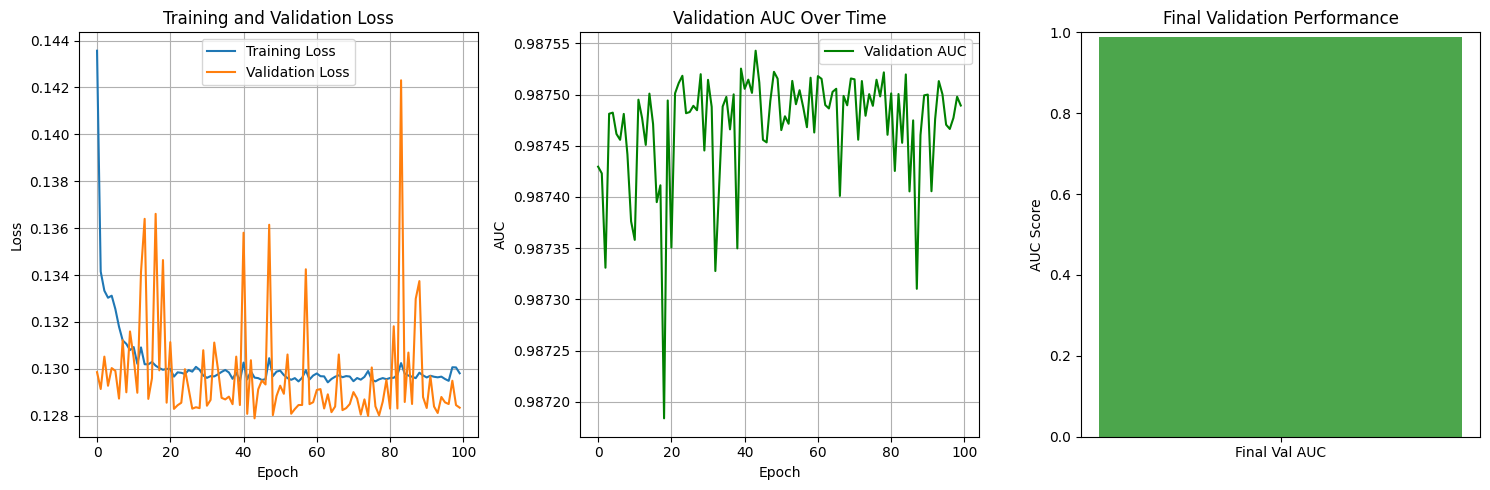


Evaluating model performance...
Test AUC: 0.9875
Average Precision: 0.9847


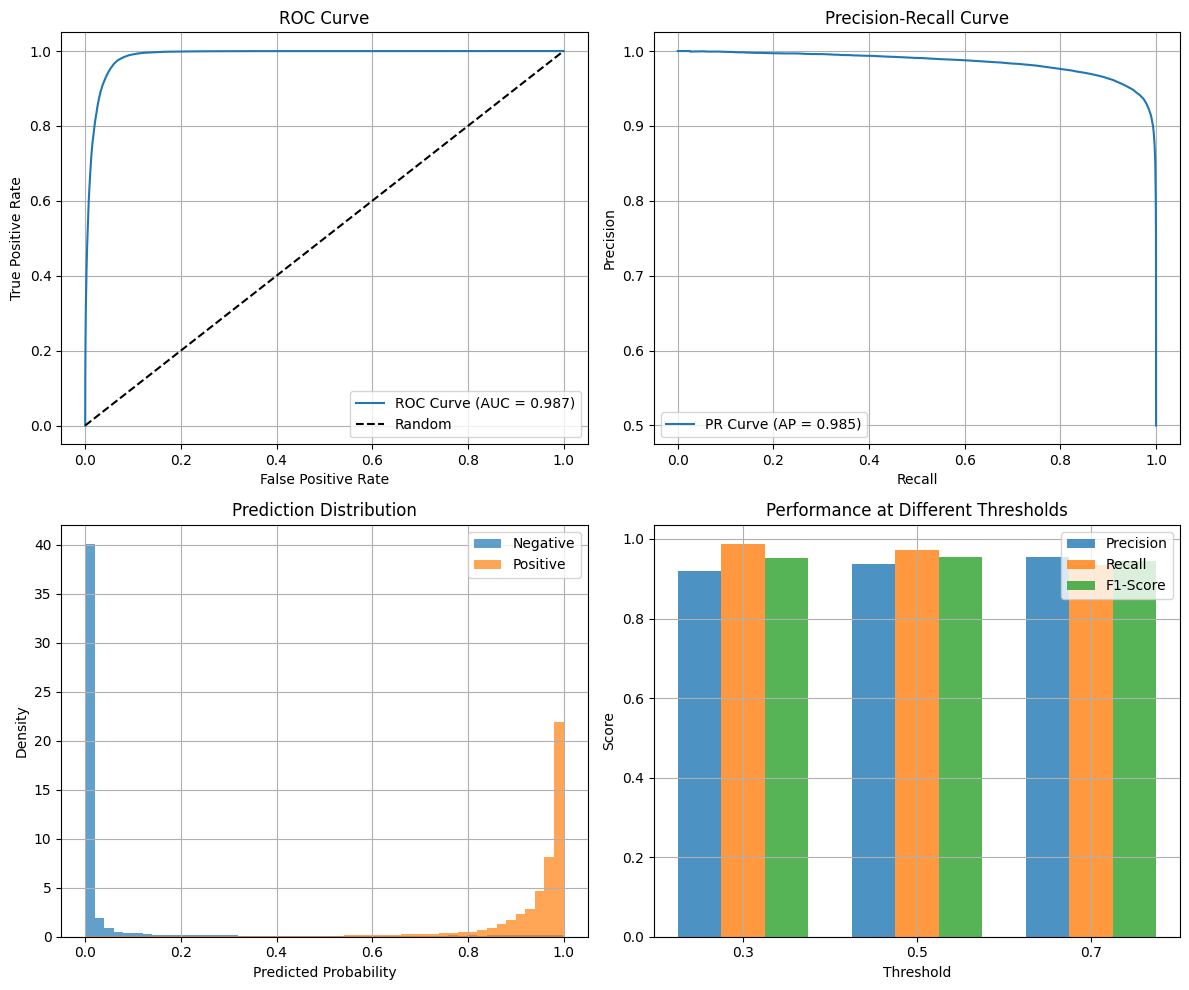

In [41]:
# Visualize training results
print("Plotting training history...")
plot_training_history(train_history)

print("\nEvaluating model performance...")
threshold_results = evaluate_model_performance(test_metrics)

CREATING EDGE PROBABILITY HEATMAP
Source degree range: 1 - 15036
Target degree range: 1 - 98


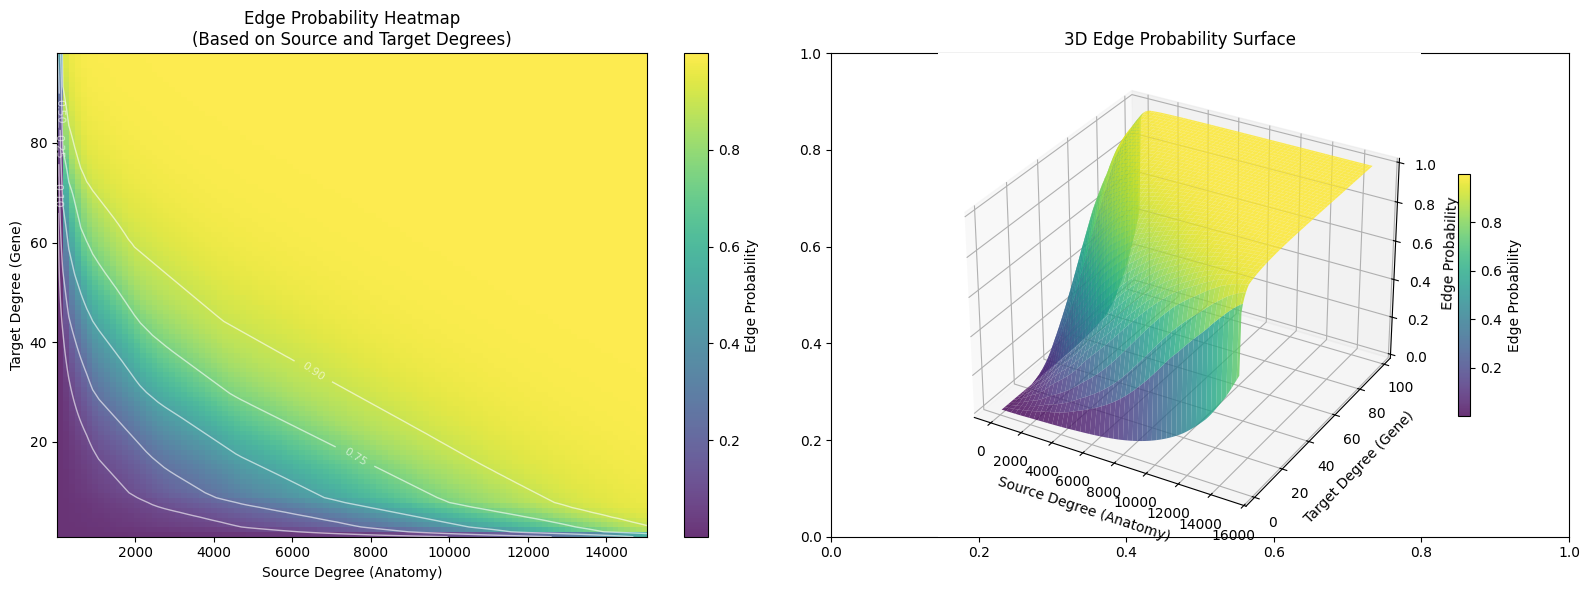

Heatmap created with resolution: (100, 100)
Probability range: 0.0000 - 1.0000
Mean probability: 0.8286
Standard deviation: 0.2800


In [42]:
def create_edge_probability_heatmap(model, scaler, degree_ranges=None, resolution=50):
    """
    Create a heatmap showing edge probability based on source and target degrees.
    
    Parameters:
    -----------
    model : EdgePredictionNN
        Trained neural network model
    scaler : StandardScaler
        Fitted scaler for feature normalization
    degree_ranges : tuple or None
        (min_degree, max_degree) for both source and target. If None, uses data ranges
    resolution : int
        Number of grid points along each axis
    
    Returns:
    --------
    tuple : (probability_matrix, source_degrees, target_degrees)
    """
    
    # Determine degree ranges from the training data if not provided
    if degree_ranges is None:
        # Get degree ranges from the current permutation data
        anatomy_degrees = np.array(aeg_edges.sum(axis=1)).flatten()
        gene_degrees = np.array(aeg_edges.sum(axis=0)).flatten()
        
        min_source = max(1, anatomy_degrees.min())  # Avoid zero degrees
        max_source = anatomy_degrees.max()
        min_target = max(1, gene_degrees.min())
        max_target = gene_degrees.max()
    else:
        min_source, max_source = degree_ranges
        min_target, max_target = degree_ranges
    
    print(f"Source degree range: {min_source} - {max_source}")
    print(f"Target degree range: {min_target} - {max_target}")
    
    # Create degree grids
    source_degrees = np.linspace(min_source, max_source, resolution)
    target_degrees = np.linspace(min_target, max_target, resolution)
    
    # Create meshgrid for all combinations
    source_grid, target_grid = np.meshgrid(source_degrees, target_degrees)
    
    # Flatten grids to create feature matrix
    features_grid = np.column_stack([
        source_grid.flatten(),
        target_grid.flatten()
    ])
    
    # Scale features using the same scaler from training
    features_scaled = scaler.transform(features_grid)
    
    # Convert to PyTorch tensor
    features_tensor = torch.FloatTensor(features_scaled)
    
    # Get predictions
    model.eval()
    with torch.no_grad():
        probabilities = model(features_tensor).cpu().numpy()
    
    # Reshape back to grid
    probability_matrix = probabilities.reshape(resolution, resolution)
    
    return probability_matrix, source_degrees, target_degrees

# Create the heatmap
print("="*60)
print("CREATING EDGE PROBABILITY HEATMAP")
print("="*60)

# Create probability heatmap
probability_matrix, source_degrees, target_degrees = create_edge_probability_heatmap(
    model, test_metrics['scaler'], resolution=100
)

# Create the visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Main heatmap
im1 = axes[0].imshow(probability_matrix, 
                     extent=[source_degrees.min(), source_degrees.max(), 
                            target_degrees.min(), target_degrees.max()],
                     origin='lower', aspect='auto', cmap='viridis', alpha=0.8)

axes[0].set_xlabel('Source Degree (Anatomy)')
axes[0].set_ylabel('Target Degree (Gene)')
axes[0].set_title('Edge Probability Heatmap\n(Based on Source and Target Degrees)')

# Add colorbar
cbar1 = plt.colorbar(im1, ax=axes[0])
cbar1.set_label('Edge Probability')

# Add contour lines
contour_levels = [0.1, 0.25, 0.5, 0.75, 0.9]
contours = axes[0].contour(source_degrees, target_degrees, probability_matrix, 
                          levels=contour_levels, colors='white', alpha=0.6, linewidths=1)
axes[0].clabel(contours, inline=True, fontsize=8, fmt='%.2f')

# Second plot: 3D surface (alternative view)
from mpl_toolkits.mplot3d import Axes3D

# Create 3D subplot
ax_3d = fig.add_subplot(122, projection='3d')
source_mesh, target_mesh = np.meshgrid(source_degrees, target_degrees)

surface = ax_3d.plot_surface(source_mesh, target_mesh, probability_matrix,
                            cmap='viridis', alpha=0.8, edgecolor='none')

ax_3d.set_xlabel('Source Degree (Anatomy)')
ax_3d.set_ylabel('Target Degree (Gene)')
ax_3d.set_zlabel('Edge Probability')
ax_3d.set_title('3D Edge Probability Surface')

# Add colorbar for 3D plot
cbar2 = plt.colorbar(surface, ax=ax_3d, shrink=0.5)
cbar2.set_label('Edge Probability')

plt.tight_layout()
plt.show()

print(f"Heatmap created with resolution: {probability_matrix.shape}")
print(f"Probability range: {probability_matrix.min():.4f} - {probability_matrix.max():.4f}")
print(f"Mean probability: {probability_matrix.mean():.4f}")
print(f"Standard deviation: {probability_matrix.std():.4f}")


DETAILED PROBABILITY ANALYSIS


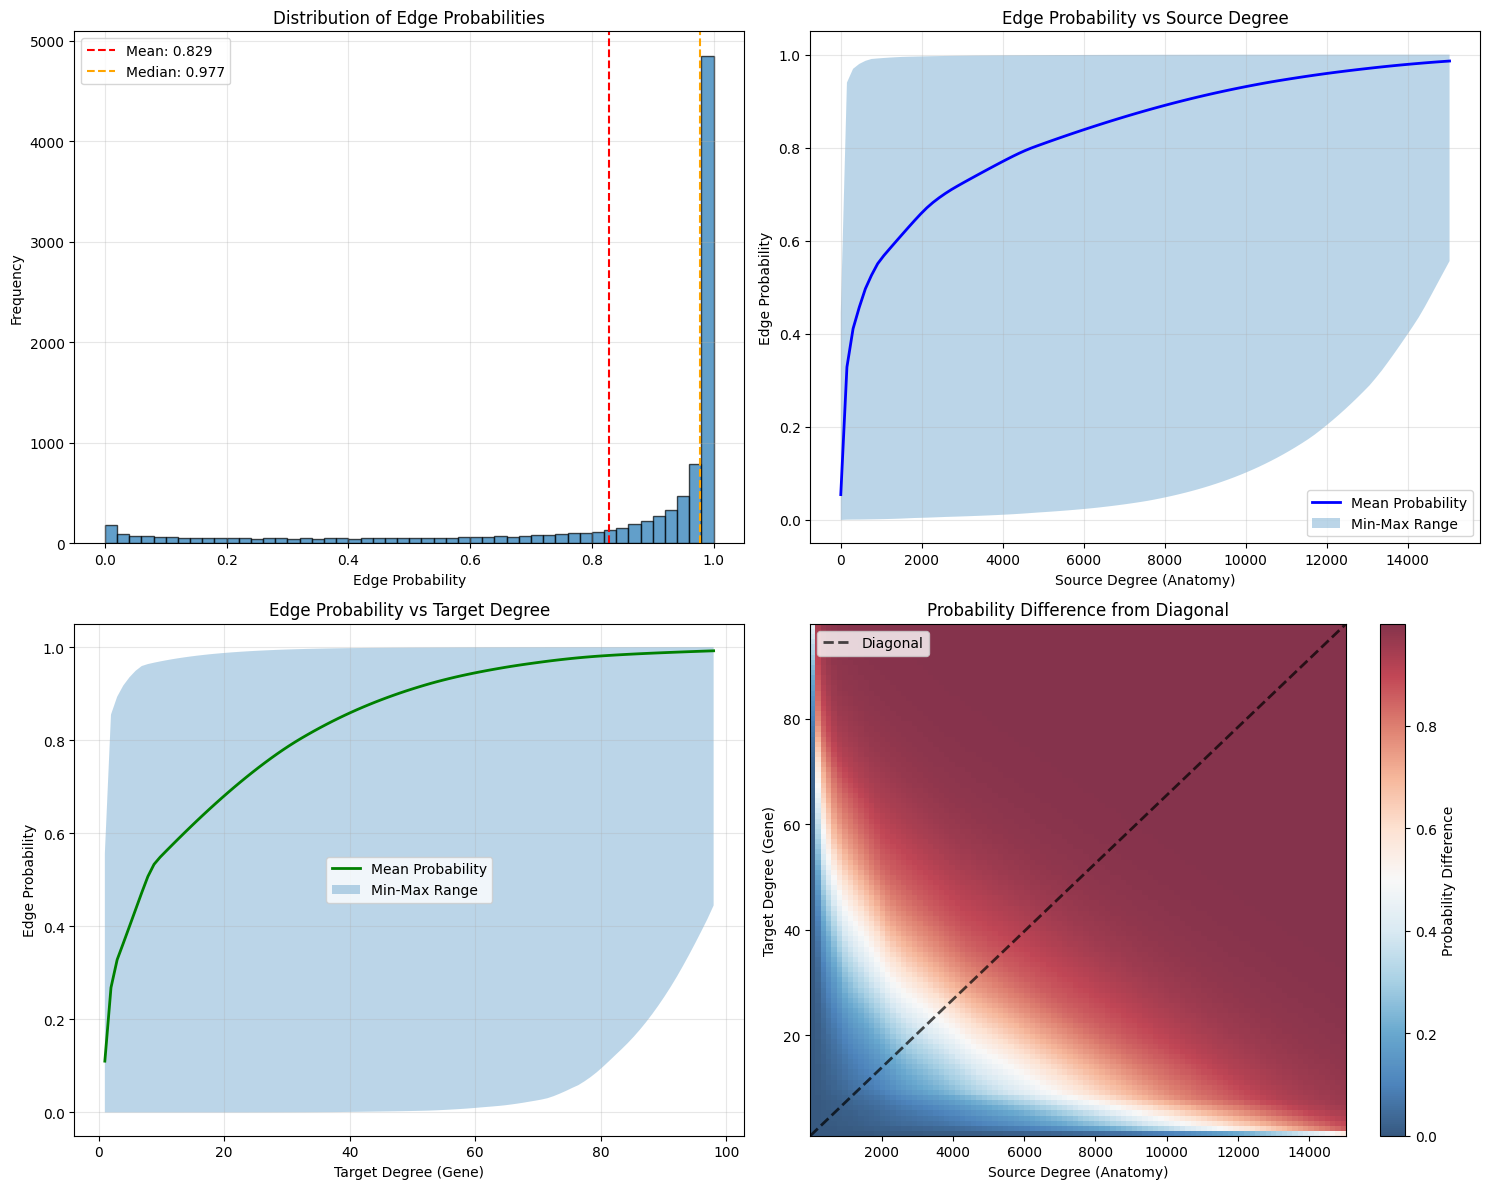


Summary Statistics:
Overall probability range: 0.0000 - 1.0000
Mean probability: 0.8286 ± 0.2800
Median probability: 0.9771

High probability regions (>90th percentile, >0.999):
  Source degree: 15036.0, Target degree: 61.7, Probability: 0.9995
  Source degree: 14732.3, Target degree: 62.7, Probability: 0.9995
  Source degree: 14884.1, Target degree: 62.7, Probability: 0.9995
  Source degree: 15036.0, Target degree: 62.7, Probability: 0.9995
  Source degree: 14580.4, Target degree: 63.7, Probability: 0.9995

Low probability regions (<10th percentile, <0.312):
  Source degree: 1.0, Target degree: 1.0, Probability: 0.0000
  Source degree: 152.9, Target degree: 1.0, Probability: 0.0007
  Source degree: 304.7, Target degree: 1.0, Probability: 0.0009
  Source degree: 456.6, Target degree: 1.0, Probability: 0.0010
  Source degree: 608.5, Target degree: 1.0, Probability: 0.0012


In [43]:
# Additional analysis: Probability patterns across degree ranges
print("\n" + "="*60)
print("DETAILED PROBABILITY ANALYSIS")
print("="*60)

# Create more detailed analysis plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Probability distribution histogram
axes[0, 0].hist(probability_matrix.flatten(), bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Edge Probability')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Edge Probabilities')
axes[0, 0].grid(True, alpha=0.3)

# Add summary statistics
mean_prob = probability_matrix.mean()
median_prob = np.median(probability_matrix)
axes[0, 0].axvline(mean_prob, color='red', linestyle='--', label=f'Mean: {mean_prob:.3f}')
axes[0, 0].axvline(median_prob, color='orange', linestyle='--', label=f'Median: {median_prob:.3f}')
axes[0, 0].legend()

# 2. Probability vs Source Degree (averaged over target degrees)
mean_prob_by_source = probability_matrix.mean(axis=0)  # Average over target degrees
axes[0, 1].plot(source_degrees, mean_prob_by_source, 'b-', linewidth=2, label='Mean Probability')
axes[0, 1].fill_between(source_degrees, 
                       probability_matrix.min(axis=0), 
                       probability_matrix.max(axis=0), 
                       alpha=0.3, label='Min-Max Range')
axes[0, 1].set_xlabel('Source Degree (Anatomy)')
axes[0, 1].set_ylabel('Edge Probability')
axes[0, 1].set_title('Edge Probability vs Source Degree')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Probability vs Target Degree (averaged over source degrees)
mean_prob_by_target = probability_matrix.mean(axis=1)  # Average over source degrees
axes[1, 0].plot(target_degrees, mean_prob_by_target, 'g-', linewidth=2, label='Mean Probability')
axes[1, 0].fill_between(target_degrees, 
                       probability_matrix.min(axis=1), 
                       probability_matrix.max(axis=1), 
                       alpha=0.3, label='Min-Max Range')
axes[1, 0].set_xlabel('Target Degree (Gene)')
axes[1, 0].set_ylabel('Edge Probability')
axes[1, 0].set_title('Edge Probability vs Target Degree')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Difference from diagonal (source degree = target degree)
# Create a heatmap showing how probability differs from the diagonal
diagonal_prob = np.diag(probability_matrix)
source_mesh, target_mesh = np.meshgrid(source_degrees, target_degrees)

# Calculate difference from diagonal expectation
diagonal_interp = np.interp(target_mesh, source_degrees, diagonal_prob)
prob_diff = probability_matrix - diagonal_interp

im = axes[1, 1].imshow(prob_diff, 
                      extent=[source_degrees.min(), source_degrees.max(), 
                             target_degrees.min(), target_degrees.max()],
                      origin='lower', aspect='auto', cmap='RdBu_r', alpha=0.8)

axes[1, 1].set_xlabel('Source Degree (Anatomy)')
axes[1, 1].set_ylabel('Target Degree (Gene)')
axes[1, 1].set_title('Probability Difference from Diagonal')

# Add diagonal line
axes[1, 1].plot([source_degrees.min(), source_degrees.max()], 
               [target_degrees.min(), target_degrees.max()], 
               'k--', linewidth=2, alpha=0.7, label='Diagonal')
axes[1, 1].legend()

# Add colorbar
cbar = plt.colorbar(im, ax=axes[1, 1])
cbar.set_label('Probability Difference')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary Statistics:")
print(f"Overall probability range: {probability_matrix.min():.4f} - {probability_matrix.max():.4f}")
print(f"Mean probability: {probability_matrix.mean():.4f} ± {probability_matrix.std():.4f}")
print(f"Median probability: {np.median(probability_matrix):.4f}")

# Find high and low probability regions
high_prob_threshold = np.percentile(probability_matrix, 90)
low_prob_threshold = np.percentile(probability_matrix, 10)

print(f"\nHigh probability regions (>90th percentile, >{high_prob_threshold:.3f}):")
high_prob_mask = probability_matrix > high_prob_threshold
high_prob_indices = np.where(high_prob_mask)
if len(high_prob_indices[0]) > 0:
    for i in range(min(5, len(high_prob_indices[0]))):  # Show first 5
        source_idx, target_idx = high_prob_indices[1][i], high_prob_indices[0][i]
        prob_val = probability_matrix[target_idx, source_idx]
        print(f"  Source degree: {source_degrees[source_idx]:.1f}, Target degree: {target_degrees[target_idx]:.1f}, Probability: {prob_val:.4f}")

print(f"\nLow probability regions (<10th percentile, <{low_prob_threshold:.3f}):")
low_prob_mask = probability_matrix < low_prob_threshold
low_prob_indices = np.where(low_prob_mask)
if len(low_prob_indices[0]) > 0:
    for i in range(min(5, len(low_prob_indices[0]))):  # Show first 5
        source_idx, target_idx = low_prob_indices[1][i], low_prob_indices[0][i]
        prob_val = probability_matrix[target_idx, source_idx]
        print(f"  Source degree: {source_degrees[source_idx]:.1f}, Target degree: {target_degrees[target_idx]:.1f}, Probability: {prob_val:.4f}")

In [44]:
def train_across_permutations(all_permutation_data, epochs=20):
    """
    Train models across all permutations and compare performance.
    
    Parameters:
    -----------
    all_permutation_data : dict
        Dictionary containing all permutation data
    epochs : int
        Number of epochs for training each model
    
    Returns:
    --------
    dict : Results for each permutation
    """
    results = {}
    
    print("="*60)
    print("TRAINING ACROSS ALL PERMUTATIONS")
    print("="*60)
    
    for perm_name, perm_data in all_permutation_data.items():
        print(f"\nTraining on permutation: {perm_name}")
        print("-" * 40)
        
        try:
            # Prepare data
            features, labels = prepare_edge_prediction_data(perm_data, sample_negative_ratio=1.0)
            
            # Train model
            model, train_history, test_metrics = train_edge_prediction_model(
                features, labels,
                epochs=epochs,
                batch_size=512,
                learning_rate=0.001
            )
            
            results[perm_name] = {
                'model': model,
                'train_history': train_history,
                'test_metrics': test_metrics,
                'features': features,
                'labels': labels
            }
            
            print(f"✓ {perm_name}: AUC = {test_metrics['auc']:.4f}, AP = {test_metrics['average_precision']:.4f}")
            
        except Exception as e:
            print(f"✗ Failed to train on {perm_name}: {e}")
            results[perm_name] = None
    
    return results

def plot_permutation_comparison(all_results):
    """Plot comparison of model performance across permutations."""
    
    # Extract metrics
    perm_names = []
    aucs = []
    aps = []
    
    for perm_name, result in all_results.items():
        if result is not None:
            perm_names.append(perm_name)
            aucs.append(result['test_metrics']['auc'])
            aps.append(result['test_metrics']['average_precision'])
    
    # Create comparison plots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # AUC comparison
    axes[0].bar(range(len(perm_names)), aucs, alpha=0.7, color='skyblue')
    axes[0].set_xlabel('Permutation')
    axes[0].set_ylabel('AUC Score')
    axes[0].set_title('AUC Scores Across Permutations')
    axes[0].set_xticks(range(len(perm_names)))
    axes[0].set_xticklabels(perm_names, rotation=45)
    axes[0].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(aucs):
        axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    # Average Precision comparison
    axes[1].bar(range(len(perm_names)), aps, alpha=0.7, color='lightcoral')
    axes[1].set_xlabel('Permutation')
    axes[1].set_ylabel('Average Precision')
    axes[1].set_title('Average Precision Scores Across Permutations')
    axes[1].set_xticks(range(len(perm_names)))
    axes[1].set_xticklabels(perm_names, rotation=45)
    axes[1].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(aps):
        axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nSummary Statistics:")
    print(f"Mean AUC: {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")
    print(f"Mean AP: {np.mean(aps):.4f} ± {np.std(aps):.4f}")
    print(f"Min AUC: {np.min(aucs):.4f}, Max AUC: {np.max(aucs):.4f}")
    print(f"Min AP: {np.min(aps):.4f}, Max AP: {np.max(aps):.4f}")

print("Multi-permutation training functions defined!")

Multi-permutation training functions defined!


TRAINING ACROSS ALL PERMUTATIONS

Training on permutation: 000.hetmat
----------------------------------------
Anatomy degree range: 0 - 15036
Gene degree range: 0 - 98
Number of positive examples (existing edges): 526407
Number of negative examples (non-existing edges): 526407
Training on 842251 samples, testing on 210563 samples
Feature shapes: (842251, 2), Labels shape: (842251,)
Number of negative examples (non-existing edges): 526407
Training on 842251 samples, testing on 210563 samples
Feature shapes: (842251, 2), Labels shape: (842251,)


Training: 100%|██████████| 20/20 [01:20<00:00,  4.05s/it]

Epoch 20/20: Train Loss: 0.1313, Val Loss: 0.1296, Val AUC: 0.9877
✓ 000.hetmat: AUC = 0.9877, AP = 0.9851

Training on permutation: 001.hetmat
----------------------------------------
Anatomy degree range: 0 - 15036
Gene degree range: 0 - 98
Number of positive examples (existing edges): 526407


Number of negative examples (non-existing edges): 526407
Training on 842251 samples, testing on 210563 samples
Feature shapes: (842251, 2), Labels shape: (842251,)
Training on 842251 samples, testing on 210563 samples
Feature shapes: (842251, 2), Labels shape: (842251,)


Training: 100%|██████████| 20/20 [01:21<00:00,  4.09s/it]

Epoch 20/20: Train Loss: 0.1319, Val Loss: 0.1456, Val AUC: 0.9876
✓ 001.hetmat: AUC = 0.9876, AP = 0.9851


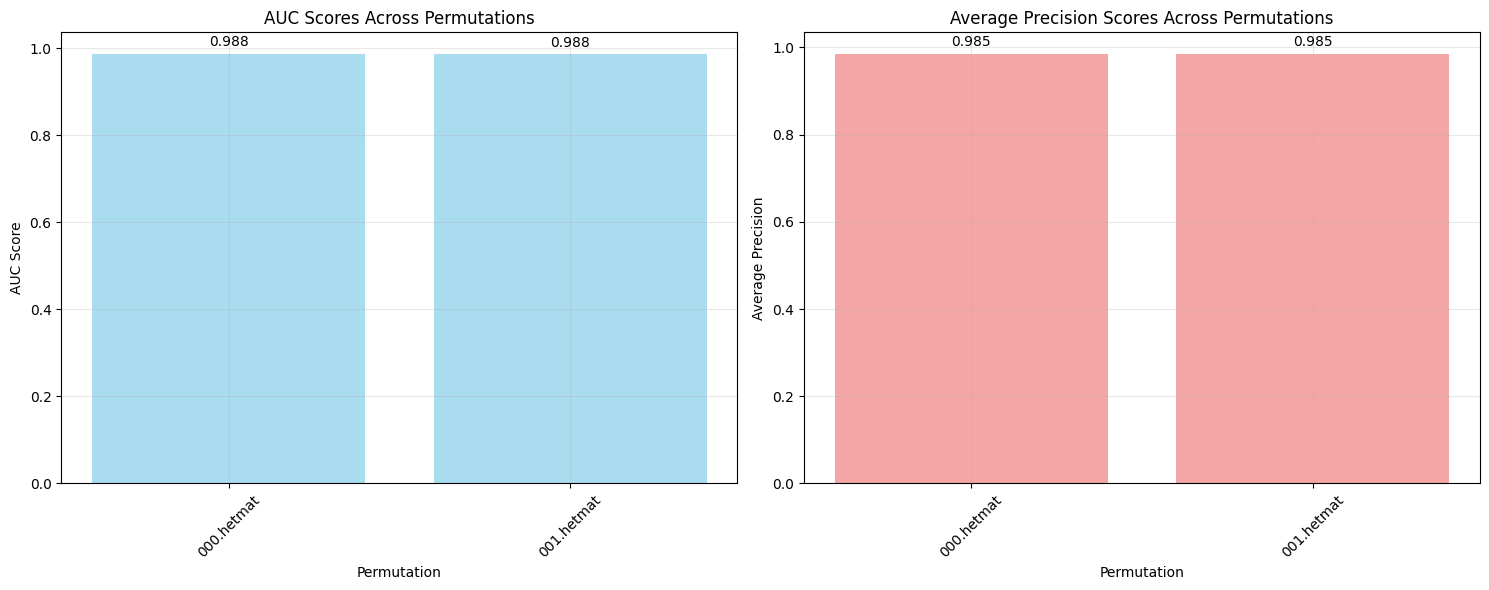


Summary Statistics:
Mean AUC: 0.9876 ± 0.0001
Mean AP: 0.9851 ± 0.0000
Min AUC: 0.9876, Max AUC: 0.9877
Min AP: 0.9851, Max AP: 0.9851
NEURAL NETWORK SETUP COMPLETE!
✓ Data loading functions defined
✓ Neural network architecture implemented
✓ Training pipeline established
✓ Evaluation and visualization tools ready
✓ Single permutation model trained

To train across all permutations, uncomment the lines above.
The model predicts edge probability based on source and target node degrees.


In [45]:
# Optional: Train across all permutations (uncomment to run)
# This will take longer as it trains a separate model for each permutation

all_results = train_across_permutations(all_perm_data, epochs=20)
plot_permutation_comparison(all_results)

print("="*60)
print("NEURAL NETWORK SETUP COMPLETE!")
print("="*60)
print("✓ Data loading functions defined")
print("✓ Neural network architecture implemented")
print("✓ Training pipeline established")
print("✓ Evaluation and visualization tools ready")
print("✓ Single permutation model trained")
print("\nTo train across all permutations, uncomment the lines above.")
print("The model predicts edge probability based on source and target node degrees.")

CREATING AVERAGE EDGE PROBABILITY HEATMAP ACROSS ALL PERMUTATIONS
Computing average heatmap with degree ranges:
Source degree range: 1 - 15036
Target degree range: 1 - 98
Resolution: 100x100
✓ Processed 000.hetmat: prob range 0.0000-1.0000
✓ Processed 001.hetmat: prob range 0.0000-1.0000

Successfully processed 2 permutations: ['000.hetmat', '001.hetmat']
Average probability range: 0.0000 - 1.0000
Average std deviation: 0.0175
Computing average heatmap with degree ranges:
Source degree range: 1 - 15036
Target degree range: 1 - 98
Resolution: 100x100
✓ Processed 000.hetmat: prob range 0.0000-1.0000
✓ Processed 001.hetmat: prob range 0.0000-1.0000

Successfully processed 2 permutations: ['000.hetmat', '001.hetmat']
Average probability range: 0.0000 - 1.0000
Average std deviation: 0.0175


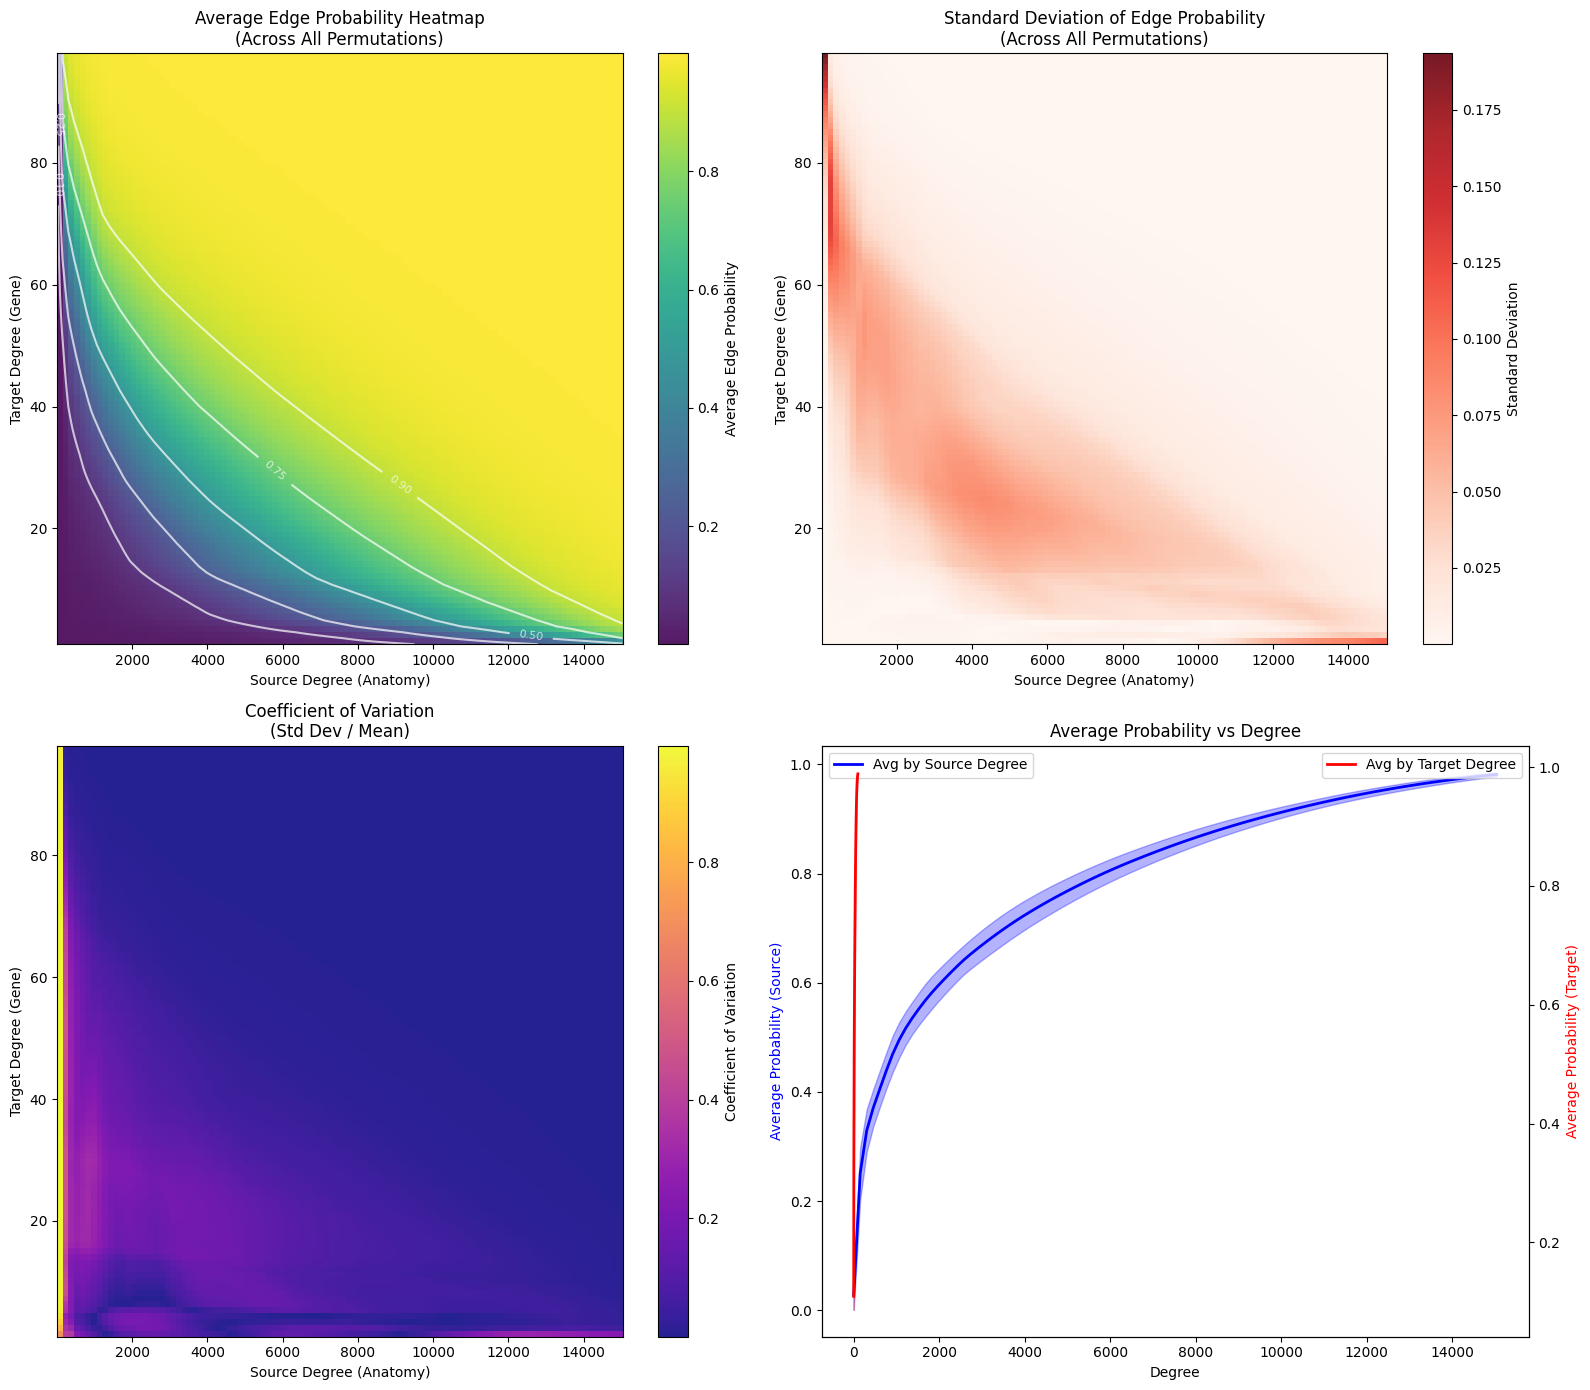


SUMMARY STATISTICS:
Average probability across all permutations: 0.7962 ± 0.3045
Average standard deviation across permutations: 0.0175
Average coefficient of variation: 0.0525
Probability range: 0.0000 - 1.0000

High variability regions (>90th percentile, std > 0.0552):
  Source: 11998.6, Target: 1.0, Avg: 0.2012, Std: 0.0560
  Source: 12150.5, Target: 1.0, Avg: 0.2096, Std: 0.0594
  Source: 12302.4, Target: 1.0, Avg: 0.2186, Std: 0.0628

Low variability regions (<10th percentile, std < 0.0000):
  Source: 1.0, Target: 1.0, Avg: 0.0000, Std: 0.0000
  Source: 1.0, Target: 2.0, Avg: 0.0000, Std: 0.0000
  Source: 1.0, Target: 3.0, Avg: 0.0000, Std: 0.0000


In [46]:
def create_average_edge_probability_heatmap(all_results, degree_ranges=None, resolution=100):
    """
    Create a heatmap showing average edge probability across all permutations 
    based on source and target degrees.
    
    Parameters:
    -----------
    all_results : dict
        Dictionary containing results from all permutations
    degree_ranges : tuple or None
        (min_degree, max_degree) for both source and target. If None, uses data ranges
    resolution : int
        Number of grid points along each axis
    
    Returns:
    --------
    tuple : (avg_probability_matrix, std_probability_matrix, source_degrees, target_degrees)
    """
    
    # Get degree ranges from the first successful permutation if not provided
    if degree_ranges is None:
        # Find first successful permutation to get degree ranges
        first_perm = None
        for perm_name, result in all_results.items():
            if result is not None:
                first_perm = perm_name
                break
        
        if first_perm is None:
            raise ValueError("No successful permutation results found")
        
        # Get degree ranges from the first permutation data
        perm_data = all_perm_data[first_perm]
        anatomy_degrees = np.array(perm_data['aeg_edges'].sum(axis=1)).flatten()
        gene_degrees = np.array(perm_data['aeg_edges'].sum(axis=0)).flatten()
        
        min_source = max(1, anatomy_degrees.min())
        max_source = anatomy_degrees.max()
        min_target = max(1, gene_degrees.min())
        max_target = gene_degrees.max()
    else:
        min_source, max_source = degree_ranges
        min_target, max_target = degree_ranges
    
    print(f"Computing average heatmap with degree ranges:")
    print(f"Source degree range: {min_source} - {max_source}")
    print(f"Target degree range: {min_target} - {max_target}")
    print(f"Resolution: {resolution}x{resolution}")
    
    # Create degree grids
    source_degrees = np.linspace(min_source, max_source, resolution)
    target_degrees = np.linspace(min_target, max_target, resolution)
    
    # Create meshgrid for all combinations
    source_grid, target_grid = np.meshgrid(source_degrees, target_degrees)
    
    # Flatten grids to create feature matrix
    features_grid = np.column_stack([
        source_grid.flatten(),
        target_grid.flatten()
    ])
    
    # Collect probability matrices from all successful permutations
    probability_matrices = []
    successful_perms = []
    
    for perm_name, result in all_results.items():
        if result is not None:
            try:
                model = result['model']
                scaler = result['test_metrics']['scaler']
                
                # Scale features using this permutation's scaler
                features_scaled = scaler.transform(features_grid)
                
                # Convert to PyTorch tensor
                features_tensor = torch.FloatTensor(features_scaled)
                
                # Get predictions
                model.eval()
                with torch.no_grad():
                    probabilities = model(features_tensor).cpu().numpy()
                
                # Reshape back to grid
                prob_matrix = probabilities.reshape(resolution, resolution)
                probability_matrices.append(prob_matrix)
                successful_perms.append(perm_name)
                
                print(f"✓ Processed {perm_name}: prob range {prob_matrix.min():.4f}-{prob_matrix.max():.4f}")
                
            except Exception as e:
                print(f"✗ Failed to process {perm_name}: {e}")
    
    if not probability_matrices:
        raise ValueError("No probability matrices could be computed")
    
    # Convert to numpy array and compute statistics
    prob_array = np.array(probability_matrices)  # Shape: (n_permutations, resolution, resolution)
    
    # Compute mean and standard deviation across permutations
    avg_probability_matrix = np.mean(prob_array, axis=0)
    std_probability_matrix = np.std(prob_array, axis=0)
    
    print(f"\nSuccessfully processed {len(probability_matrices)} permutations: {successful_perms}")
    print(f"Average probability range: {avg_probability_matrix.min():.4f} - {avg_probability_matrix.max():.4f}")
    print(f"Average std deviation: {std_probability_matrix.mean():.4f}")
    
    return avg_probability_matrix, std_probability_matrix, source_degrees, target_degrees

# Create the average heatmap across all permutations
print("="*70)
print("CREATING AVERAGE EDGE PROBABILITY HEATMAP ACROSS ALL PERMUTATIONS")
print("="*70)

# Compute average probability heatmap
avg_prob_matrix, std_prob_matrix, source_degs, target_degs = create_average_edge_probability_heatmap(
    all_results, resolution=100
)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. Average probability heatmap
im1 = axes[0, 0].imshow(avg_prob_matrix, 
                        extent=[source_degs.min(), source_degs.max(), 
                               target_degs.min(), target_degs.max()],
                        origin='lower', aspect='auto', cmap='viridis', alpha=0.9)

axes[0, 0].set_xlabel('Source Degree (Anatomy)')
axes[0, 0].set_ylabel('Target Degree (Gene)')
axes[0, 0].set_title('Average Edge Probability Heatmap\n(Across All Permutations)')

# Add colorbar
cbar1 = plt.colorbar(im1, ax=axes[0, 0])
cbar1.set_label('Average Edge Probability')

# Add contour lines for average probabilities
contour_levels = [0.1, 0.25, 0.5, 0.75, 0.9]
contours1 = axes[0, 0].contour(source_degs, target_degs, avg_prob_matrix, 
                               levels=contour_levels, colors='white', alpha=0.7, linewidths=1.5)
axes[0, 0].clabel(contours1, inline=True, fontsize=8, fmt='%.2f')

# 2. Standard deviation heatmap
im2 = axes[0, 1].imshow(std_prob_matrix, 
                        extent=[source_degs.min(), source_degs.max(), 
                               target_degs.min(), target_degs.max()],
                        origin='lower', aspect='auto', cmap='Reds', alpha=0.9)

axes[0, 1].set_xlabel('Source Degree (Anatomy)')
axes[0, 1].set_ylabel('Target Degree (Gene)')
axes[0, 1].set_title('Standard Deviation of Edge Probability\n(Across All Permutations)')

cbar2 = plt.colorbar(im2, ax=axes[0, 1])
cbar2.set_label('Standard Deviation')

# 3. Coefficient of variation (std/mean) heatmap
cv_matrix = std_prob_matrix / (avg_prob_matrix + 1e-8)  # Add small epsilon to avoid division by zero
im3 = axes[1, 0].imshow(cv_matrix, 
                        extent=[source_degs.min(), source_degs.max(), 
                               target_degs.min(), target_degs.max()],
                        origin='lower', aspect='auto', cmap='plasma', alpha=0.9)

axes[1, 0].set_xlabel('Source Degree (Anatomy)')
axes[1, 0].set_ylabel('Target Degree (Gene)')
axes[1, 0].set_title('Coefficient of Variation\n(Std Dev / Mean)')

cbar3 = plt.colorbar(im3, ax=axes[1, 0])
cbar3.set_label('Coefficient of Variation')

# 4. Average probability vs source and target degree (1D views)
# Average over target degrees for source degree analysis
avg_by_source = avg_prob_matrix.mean(axis=0)
std_by_source = std_prob_matrix.mean(axis=0)

# Average over source degrees for target degree analysis
avg_by_target = avg_prob_matrix.mean(axis=1)
std_by_target = std_prob_matrix.mean(axis=1)

axes[1, 1].plot(source_degs, avg_by_source, 'b-', linewidth=2, label='Avg by Source Degree')
axes[1, 1].fill_between(source_degs, 
                       avg_by_source - std_by_source, 
                       avg_by_source + std_by_source, 
                       alpha=0.3, color='blue')

ax_twin = axes[1, 1].twinx()
ax_twin.plot(target_degs, avg_by_target, 'r-', linewidth=2, label='Avg by Target Degree')
ax_twin.fill_between(target_degs, 
                    avg_by_target - std_by_target, 
                    avg_by_target + std_by_target, 
                    alpha=0.3, color='red')

axes[1, 1].set_xlabel('Degree')
axes[1, 1].set_ylabel('Average Probability (Source)', color='blue')
ax_twin.set_ylabel('Average Probability (Target)', color='red')
axes[1, 1].set_title('Average Probability vs Degree')

# Add legends
axes[1, 1].legend(loc='upper left')
ax_twin.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSUMMARY STATISTICS:")
print(f"Average probability across all permutations: {avg_prob_matrix.mean():.4f} ± {avg_prob_matrix.std():.4f}")
print(f"Average standard deviation across permutations: {std_prob_matrix.mean():.4f}")
print(f"Average coefficient of variation: {cv_matrix.mean():.4f}")
print(f"Probability range: {avg_prob_matrix.min():.4f} - {avg_prob_matrix.max():.4f}")

# Find regions with highest and lowest variability
high_var_threshold = np.percentile(std_prob_matrix, 90)
low_var_threshold = np.percentile(std_prob_matrix, 10)

print(f"\nHigh variability regions (>90th percentile, std > {high_var_threshold:.4f}):")
high_var_indices = np.where(std_prob_matrix > high_var_threshold)
if len(high_var_indices[0]) > 0:
    for i in range(min(3, len(high_var_indices[0]))):
        target_idx, source_idx = high_var_indices[0][i], high_var_indices[1][i]
        avg_val = avg_prob_matrix[target_idx, source_idx]
        std_val = std_prob_matrix[target_idx, source_idx]
        print(f"  Source: {source_degs[source_idx]:.1f}, Target: {target_degs[target_idx]:.1f}, "
              f"Avg: {avg_val:.4f}, Std: {std_val:.4f}")

print(f"\nLow variability regions (<10th percentile, std < {low_var_threshold:.4f}):")
low_var_indices = np.where(std_prob_matrix < low_var_threshold)
if len(low_var_indices[0]) > 0:
    for i in range(min(3, len(low_var_indices[0]))):
        target_idx, source_idx = low_var_indices[0][i], low_var_indices[1][i]
        avg_val = avg_prob_matrix[target_idx, source_idx]
        std_val = std_prob_matrix[target_idx, source_idx]
        print(f"  Source: {source_degs[source_idx]:.1f}, Target: {target_degs[target_idx]:.1f}, "
              f"Avg: {avg_val:.4f}, Std: {std_val:.4f}")

SIMPLE REGRESSION MODELS vs NEURAL NETWORK COMPARISON
Training simple regression models...
1. Training Logistic Regression...
Training simple regression models...
1. Training Logistic Regression...
   AUC: 0.9781, AP: 0.9752
2. Training Polynomial Logistic Regression (degree=2)...
   AUC: 0.9781, AP: 0.9752
2. Training Polynomial Logistic Regression (degree=2)...
   AUC: 0.9843, AP: 0.9818
3. Training Random Forest...
   AUC: 0.9843, AP: 0.9818
3. Training Random Forest...
   AUC: 0.9855, AP: 0.9814

MODEL COMPARISON RESULTS
Model                          AUC      AP       Δ AUC    Δ AP    
--------------------------------------------------------------
Neural Network                 0.9875   0.9847   +0.0000 +0.0000
Logistic Regression            0.9781   0.9752   -0.0094 -0.0095
Polynomial Logistic Regression 0.9843   0.9818   -0.0032 -0.0029
Random Forest                  0.9855   0.9814   -0.0020 -0.0033
   AUC: 0.9855, AP: 0.9814

MODEL COMPARISON RESULTS
Model                     

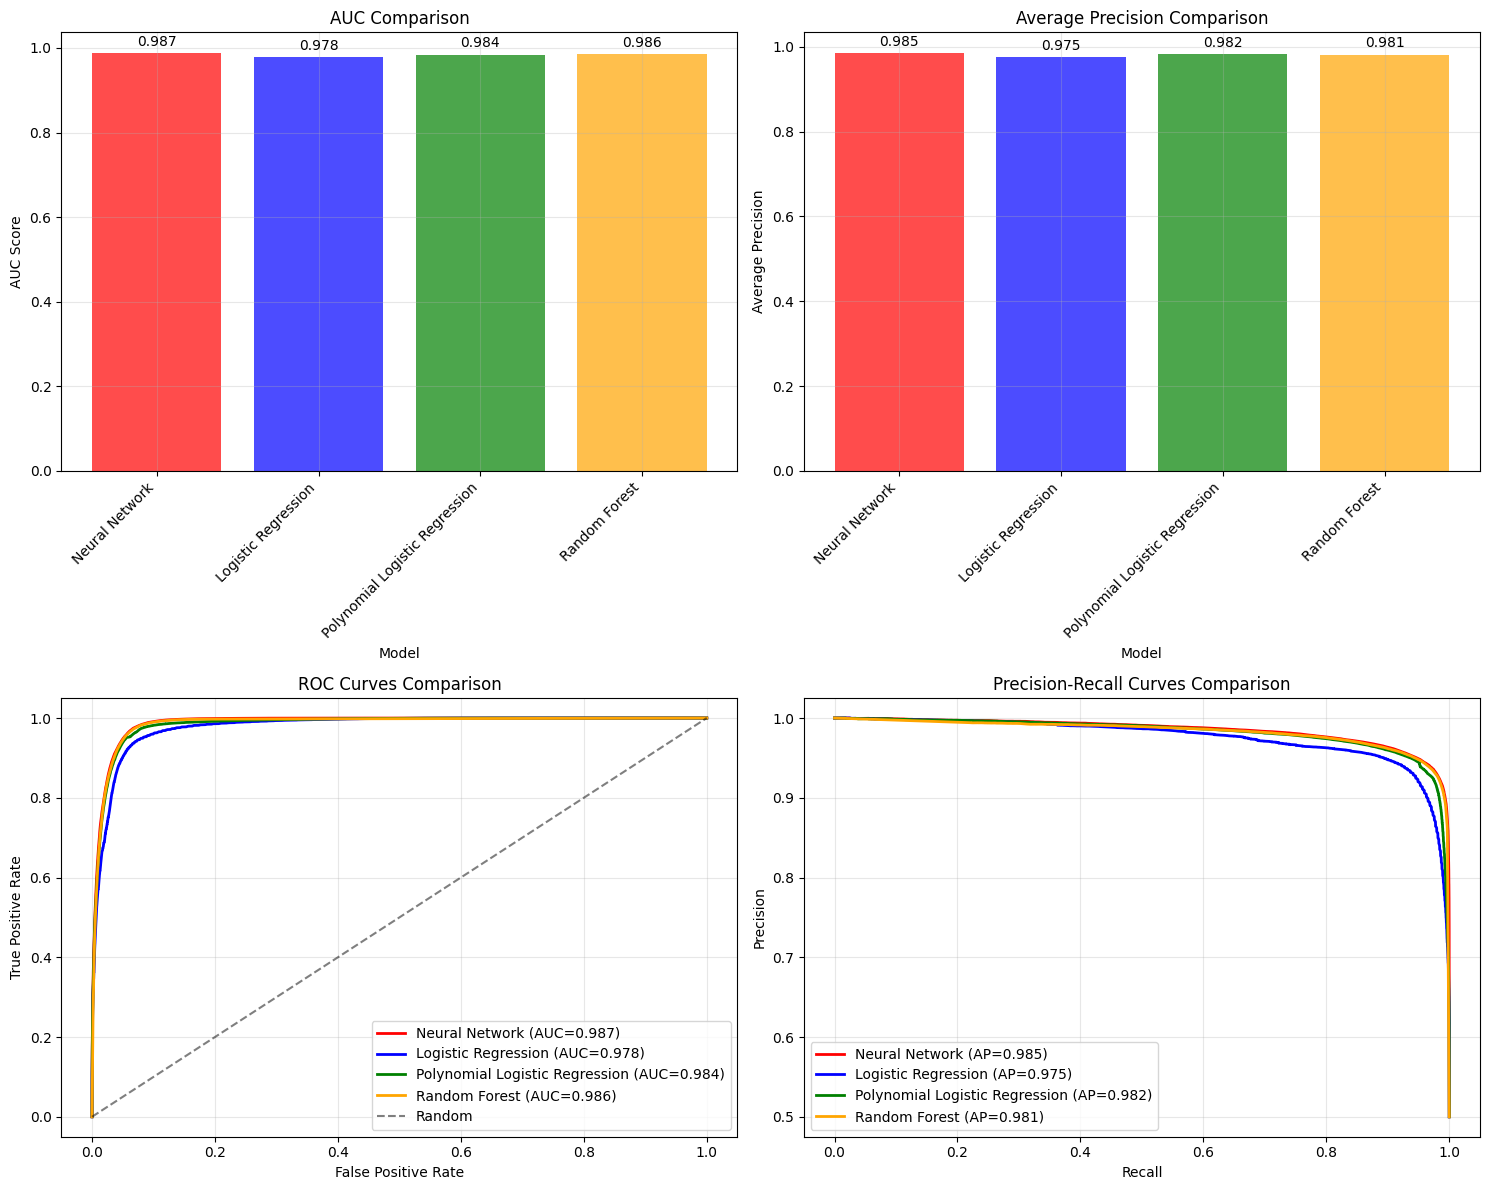

In [47]:
# Import additional regression models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

def train_simple_regression_models(features, labels, test_size=0.2):
    """
    Train simple regression models and compare with neural network performance.
    
    Parameters:
    -----------
    features : numpy.ndarray
        Feature matrix with source and target degrees
    labels : numpy.ndarray
        Binary labels for edge existence
    test_size : float
        Proportion of data for testing
    
    Returns:
    --------
    dict : Results for each model type
    """
    
    # Split data (same as neural network)
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=test_size, random_state=42, stratify=labels
    )
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Create polynomial features for more complex relationships
    poly_features = PolynomialFeatures(degree=2, include_bias=False)
    X_train_poly = poly_features.fit_transform(X_train_scaled)
    X_test_poly = poly_features.transform(X_test_scaled)
    
    results = {}
    
    print("Training simple regression models...")
    print("="*50)
    
    # 1. Simple Logistic Regression
    print("1. Training Logistic Regression...")
    lr_model = LogisticRegression(random_state=42, max_iter=1000)
    lr_model.fit(X_train_scaled, y_train)
    
    lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]
    lr_auc = roc_auc_score(y_test, lr_pred_proba)
    lr_ap = average_precision_score(y_test, lr_pred_proba)
    
    results['logistic'] = {
        'model': lr_model,
        'predictions': lr_pred_proba,
        'auc': lr_auc,
        'ap': lr_ap,
        'scaler': scaler,
        'name': 'Logistic Regression'
    }
    
    print(f"   AUC: {lr_auc:.4f}, AP: {lr_ap:.4f}")
    
    # 2. Polynomial Logistic Regression
    print("2. Training Polynomial Logistic Regression (degree=2)...")
    poly_lr_model = LogisticRegression(random_state=42, max_iter=1000)
    poly_lr_model.fit(X_train_poly, y_train)
    
    poly_lr_pred_proba = poly_lr_model.predict_proba(X_test_poly)[:, 1]
    poly_lr_auc = roc_auc_score(y_test, poly_lr_pred_proba)
    poly_lr_ap = average_precision_score(y_test, poly_lr_pred_proba)
    
    results['poly_logistic'] = {
        'model': poly_lr_model,
        'predictions': poly_lr_pred_proba,
        'auc': poly_lr_auc,
        'ap': poly_lr_ap,
        'scaler': scaler,
        'poly_features': poly_features,
        'name': 'Polynomial Logistic Regression'
    }
    
    print(f"   AUC: {poly_lr_auc:.4f}, AP: {poly_lr_ap:.4f}")
    
    # 3. Random Forest
    print("3. Training Random Forest...")
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_train_scaled, y_train)
    
    rf_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]
    rf_auc = roc_auc_score(y_test, rf_pred_proba)
    rf_ap = average_precision_score(y_test, rf_pred_proba)
    
    results['random_forest'] = {
        'model': rf_model,
        'predictions': rf_pred_proba,
        'auc': rf_auc,
        'ap': rf_ap,
        'scaler': scaler,
        'name': 'Random Forest'
    }
    
    print(f"   AUC: {rf_auc:.4f}, AP: {rf_ap:.4f}")
    
    # Store test data for comparison
    results['test_data'] = {
        'X_test': X_test,
        'X_test_scaled': X_test_scaled,
        'X_test_poly': X_test_poly,
        'y_test': y_test
    }
    
    return results

def compare_models(regression_results, nn_results):
    """
    Compare regression models with neural network results.
    """
    
    print("\n" + "="*60)
    print("MODEL COMPARISON RESULTS")
    print("="*60)
    
    # Extract metrics
    models_data = []
    
    # Add neural network results
    models_data.append({
        'name': 'Neural Network',
        'auc': nn_results['auc'],
        'ap': nn_results['average_precision'],
        'predictions': nn_results['predictions']
    })
    
    # Add regression model results
    for model_key, result in regression_results.items():
        if model_key != 'test_data':
            models_data.append({
                'name': result['name'],
                'auc': result['auc'],
                'ap': result['ap'],
                'predictions': result['predictions']
            })
    
    # Create comparison table
    print(f"{'Model':<30} {'AUC':<8} {'AP':<8} {'Δ AUC':<8} {'Δ AP':<8}")
    print("-" * 62)
    
    nn_auc = models_data[0]['auc']
    nn_ap = models_data[0]['ap']
    
    for model_data in models_data:
        delta_auc = model_data['auc'] - nn_auc
        delta_ap = model_data['ap'] - nn_ap
        
        print(f"{model_data['name']:<30} {model_data['auc']:<8.4f} {model_data['ap']:<8.4f} "
              f"{delta_auc:>+7.4f} {delta_ap:>+7.4f}")
    
    # Create visualization comparing all models
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. AUC Comparison
    model_names = [m['name'] for m in models_data]
    aucs = [m['auc'] for m in models_data]
    aps = [m['ap'] for m in models_data]
    
    colors = ['red', 'blue', 'green', 'orange']
    bars1 = axes[0, 0].bar(range(len(model_names)), aucs, color=colors[:len(model_names)], alpha=0.7)
    axes[0, 0].set_xlabel('Model')
    axes[0, 0].set_ylabel('AUC Score')
    axes[0, 0].set_title('AUC Comparison')
    axes[0, 0].set_xticks(range(len(model_names)))
    axes[0, 0].set_xticklabels(model_names, rotation=45, ha='right')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, auc) in enumerate(zip(bars1, aucs)):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                       f'{auc:.3f}', ha='center', va='bottom')
    
    # 2. AP Comparison
    bars2 = axes[0, 1].bar(range(len(model_names)), aps, color=colors[:len(model_names)], alpha=0.7)
    axes[0, 1].set_xlabel('Model')
    axes[0, 1].set_ylabel('Average Precision')
    axes[0, 1].set_title('Average Precision Comparison')
    axes[0, 1].set_xticks(range(len(model_names)))
    axes[0, 1].set_xticklabels(model_names, rotation=45, ha='right')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, ap) in enumerate(zip(bars2, aps)):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                       f'{ap:.3f}', ha='center', va='bottom')
    
    # 3. ROC Curves
    y_test = regression_results['test_data']['y_test']
    
    for i, model_data in enumerate(models_data):
        fpr, tpr, _ = roc_curve(y_test, model_data['predictions'])
        axes[1, 0].plot(fpr, tpr, label=f"{model_data['name']} (AUC={model_data['auc']:.3f})", 
                       color=colors[i], linewidth=2)
    
    axes[1, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
    axes[1, 0].set_xlabel('False Positive Rate')
    axes[1, 0].set_ylabel('True Positive Rate')
    axes[1, 0].set_title('ROC Curves Comparison')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Precision-Recall Curves
    for i, model_data in enumerate(models_data):
        precision, recall, _ = precision_recall_curve(y_test, model_data['predictions'])
        axes[1, 1].plot(recall, precision, label=f"{model_data['name']} (AP={model_data['ap']:.3f})", 
                       color=colors[i], linewidth=2)
    
    axes[1, 1].set_xlabel('Recall')
    axes[1, 1].set_ylabel('Precision')
    axes[1, 1].set_title('Precision-Recall Curves Comparison')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return models_data

# Train regression models and compare with neural network
print("="*70)
print("SIMPLE REGRESSION MODELS vs NEURAL NETWORK COMPARISON")
print("="*70)

# Use the same training data as the neural network
regression_results = train_simple_regression_models(features, labels, test_size=0.2)

# Compare with neural network results
comparison_results = compare_models(regression_results, test_metrics)


HEATMAP COMPARISON: REGRESSION MODELS vs NEURAL NETWORK
Creating heatmaps for regression models...
Processing Logistic Regression...
Processing Polynomial Logistic Regression...
Processing Random Forest...


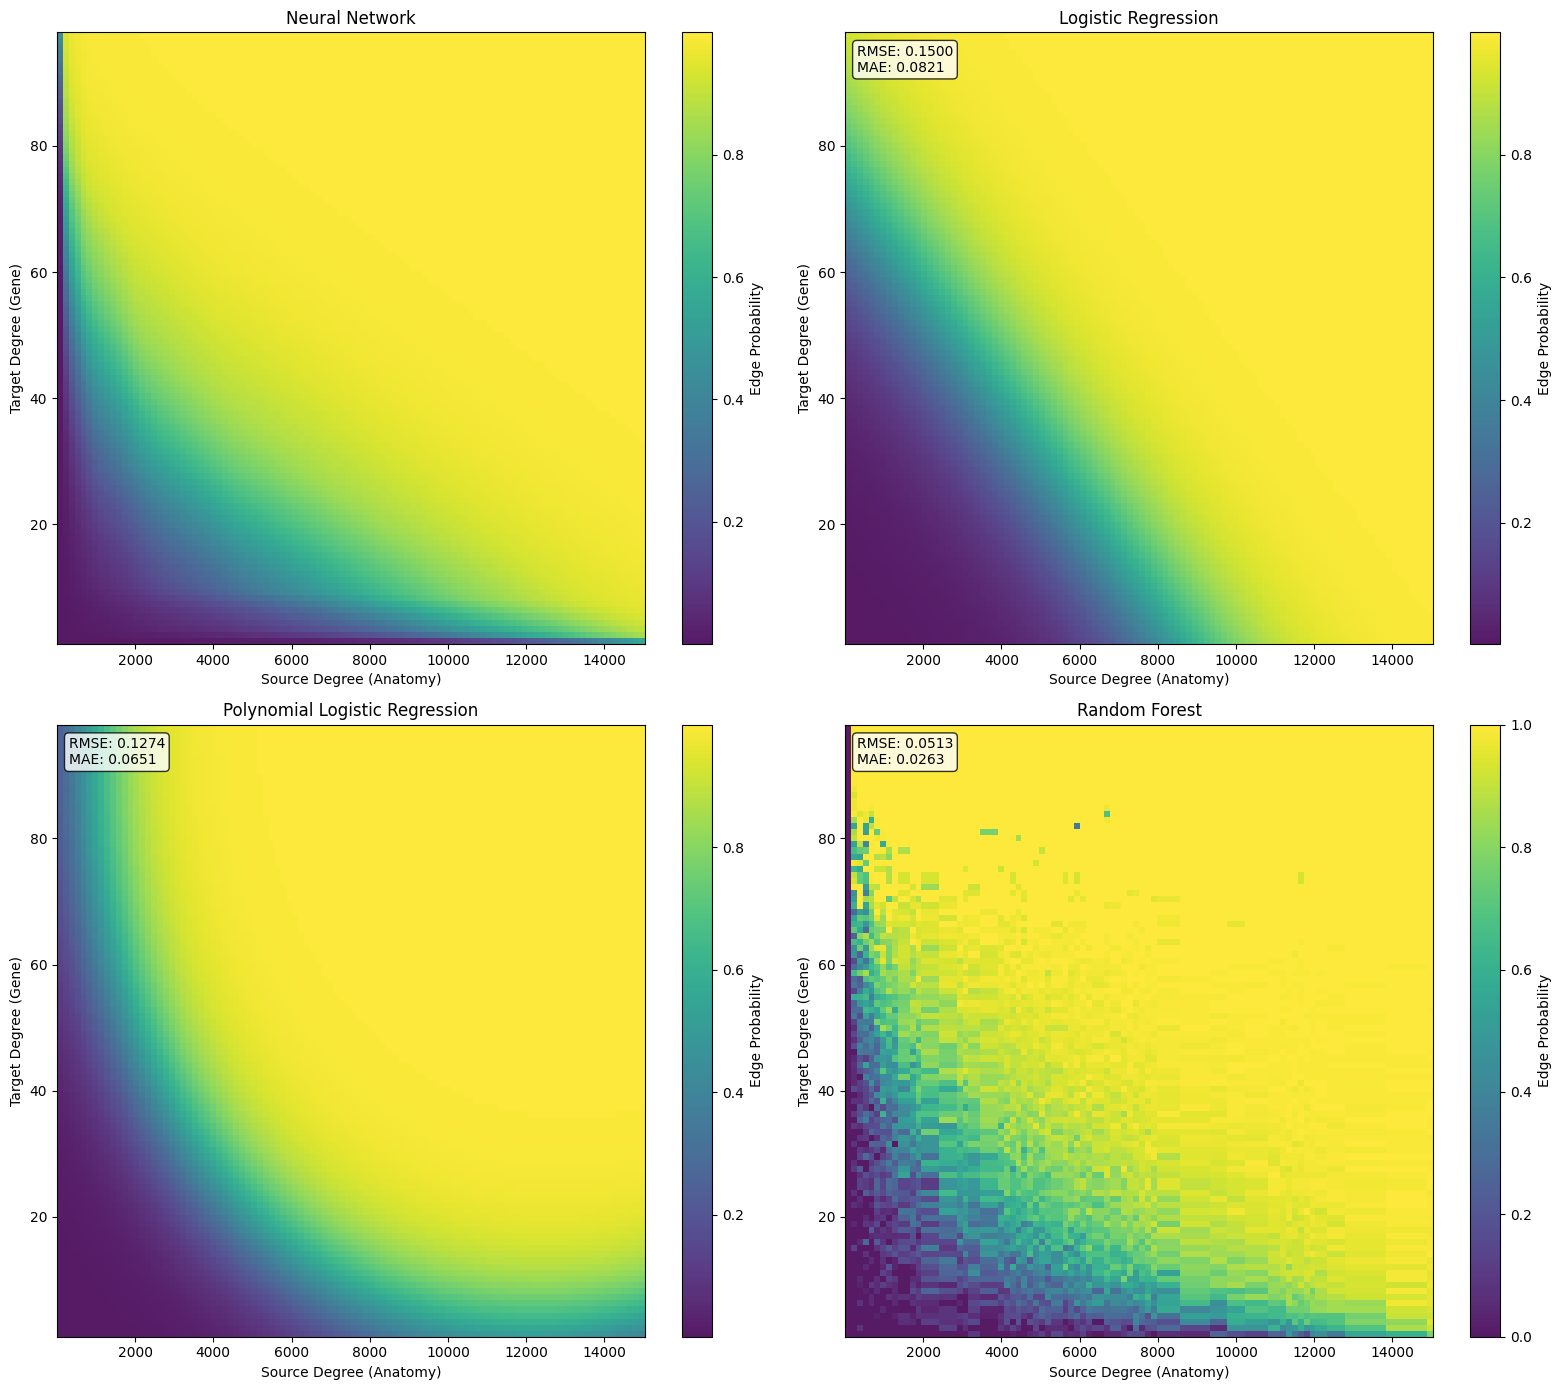


Logistic Regression vs Neural Network:
  RMSE: 0.1500
  MAE: 0.0821
  Max positive diff: 0.7487
  Max negative diff: -0.4655
  Correlation: 0.9053

Polynomial Logistic Regression vs Neural Network:
  RMSE: 0.1274
  MAE: 0.0651
  Max positive diff: 0.3591
  Max negative diff: -0.6499
  Correlation: 0.9315

Random Forest vs Neural Network:
  RMSE: 0.0513
  MAE: 0.0263
  Max positive diff: 0.3785
  Max negative diff: -0.6475
  Correlation: 0.9836


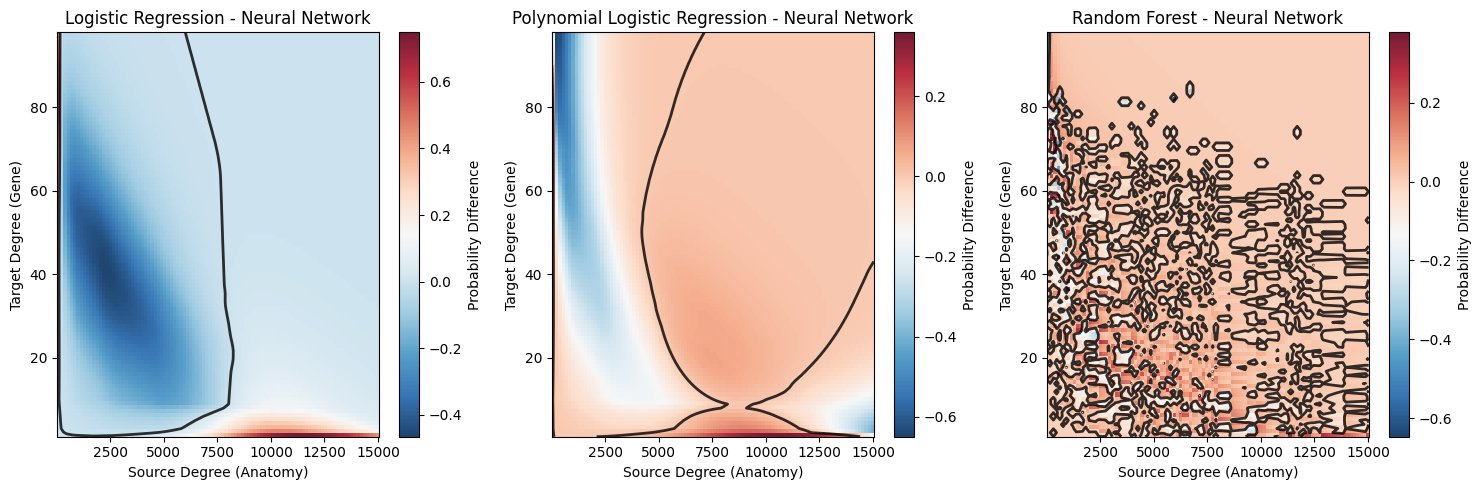


SUMMARY: SIMPLE REGRESSION vs NEURAL NETWORK

Key Findings:
1. Performance Comparison:
   Logistic Regression: ΔaUC = -0.0094, ΔAP = -0.0095
   Polynomial Logistic Regression: ΔaUC = -0.0032, ΔAP = -0.0029
   Random Forest: ΔaUC = -0.0020, ΔAP = -0.0033

2. Neural Network Performance:
   AUC: 0.9875
   Average Precision: 0.9847

3. Best Simple Model:
   Random Forest: AUC = 0.9855

4. Interpretation:
   Neural network and simple models perform similarly.
   The relationship may be approximately linear or simple polynomial.

5. Recommendation:
   Consider using simpler model for interpretability.


In [48]:
def create_regression_heatmaps(regression_results, nn_scaler, degree_ranges=None, resolution=100):
    """
    Create heatmaps for regression models to compare with neural network.
    
    Parameters:
    -----------
    regression_results : dict
        Results from regression models
    nn_scaler : StandardScaler
        Scaler used for neural network (for fair comparison)
    degree_ranges : tuple or None
        Degree ranges for heatmap
    resolution : int
        Grid resolution
    
    Returns:
    --------
    dict : Heatmaps for each model
    """
    
    # Get degree ranges
    if degree_ranges is None:
        anatomy_degrees = np.array(aeg_edges.sum(axis=1)).flatten()
        gene_degrees = np.array(aeg_edges.sum(axis=0)).flatten()
        
        min_source = max(1, anatomy_degrees.min())
        max_source = anatomy_degrees.max()
        min_target = max(1, gene_degrees.min())
        max_target = gene_degrees.max()
    else:
        min_source, max_source = degree_ranges
        min_target, max_target = degree_ranges
    
    # Create degree grids
    source_degrees = np.linspace(min_source, max_source, resolution)
    target_degrees = np.linspace(min_target, max_target, resolution)
    source_grid, target_grid = np.meshgrid(source_degrees, target_degrees)
    
    # Create feature matrix
    features_grid = np.column_stack([
        source_grid.flatten(),
        target_grid.flatten()
    ])
    
    # Scale features using neural network scaler for fair comparison
    features_scaled = nn_scaler.transform(features_grid)
    
    heatmaps = {}
    
    print("Creating heatmaps for regression models...")
    
    # Create heatmaps for each model
    for model_key, result in regression_results.items():
        if model_key == 'test_data':
            continue
            
        model = result['model']
        model_name = result['name']
        
        print(f"Processing {model_name}...")
        
        if model_key == 'poly_logistic':
            # For polynomial features
            poly_features = result['poly_features']
            features_poly = poly_features.transform(features_scaled)
            probabilities = model.predict_proba(features_poly)[:, 1]
        else:
            # For regular models
            probabilities = model.predict_proba(features_scaled)[:, 1]
        
        # Reshape to grid
        prob_matrix = probabilities.reshape(resolution, resolution)
        heatmaps[model_key] = {
            'matrix': prob_matrix,
            'name': model_name
        }
    
    return heatmaps, source_degrees, target_degrees

def plot_model_heatmap_comparison(regression_heatmaps, nn_heatmap, source_degrees, target_degrees):
    """
    Plot heatmap comparison between regression models and neural network.
    """
    
    # Create subplots
    n_models = len(regression_heatmaps) + 1  # +1 for neural network
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    axes = axes.flatten()
    
    extent = [source_degrees.min(), source_degrees.max(), 
              target_degrees.min(), target_degrees.max()]
    
    # Plot neural network heatmap
    im0 = axes[0].imshow(nn_heatmap, extent=extent, origin='lower', 
                        aspect='auto', cmap='viridis', alpha=0.9)
    axes[0].set_title('Neural Network')
    axes[0].set_xlabel('Source Degree (Anatomy)')
    axes[0].set_ylabel('Target Degree (Gene)')
    cbar0 = plt.colorbar(im0, ax=axes[0])
    cbar0.set_label('Edge Probability')
    
    # Plot regression model heatmaps
    for i, (model_key, heatmap_data) in enumerate(regression_heatmaps.items()):
        ax_idx = i + 1
        if ax_idx >= len(axes):
            break
            
        matrix = heatmap_data['matrix']
        name = heatmap_data['name']
        
        im = axes[ax_idx].imshow(matrix, extent=extent, origin='lower', 
                               aspect='auto', cmap='viridis', alpha=0.9)
        axes[ax_idx].set_title(name)
        axes[ax_idx].set_xlabel('Source Degree (Anatomy)')
        axes[ax_idx].set_ylabel('Target Degree (Gene)')
        
        cbar = plt.colorbar(im, ax=axes[ax_idx])
        cbar.set_label('Edge Probability')
        
        # Add difference statistics
        diff = matrix - nn_heatmap
        rmse = np.sqrt(np.mean(diff**2))
        mae = np.mean(np.abs(diff))
        
        axes[ax_idx].text(0.02, 0.98, f'RMSE: {rmse:.4f}\nMAE: {mae:.4f}', 
                         transform=axes[ax_idx].transAxes, verticalalignment='top',
                         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Create difference heatmaps
    fig2, axes2 = plt.subplots(1, len(regression_heatmaps), figsize=(15, 5))
    if len(regression_heatmaps) == 1:
        axes2 = [axes2]
    
    for i, (model_key, heatmap_data) in enumerate(regression_heatmaps.items()):
        matrix = heatmap_data['matrix']
        name = heatmap_data['name']
        
        # Calculate difference from neural network
        diff = matrix - nn_heatmap
        
        im = axes2[i].imshow(diff, extent=extent, origin='lower', 
                           aspect='auto', cmap='RdBu_r', alpha=0.9)
        axes2[i].set_title(f'{name} - Neural Network')
        axes2[i].set_xlabel('Source Degree (Anatomy)')
        axes2[i].set_ylabel('Target Degree (Gene)')
        
        # Add contour lines at zero difference
        axes2[i].contour(source_degrees, target_degrees, diff, 
                        levels=[0], colors='black', alpha=0.8, linewidths=2)
        
        cbar = plt.colorbar(im, ax=axes2[i])
        cbar.set_label('Probability Difference')
        
        # Print statistics
        print(f"\n{name} vs Neural Network:")
        print(f"  RMSE: {np.sqrt(np.mean(diff**2)):.4f}")
        print(f"  MAE: {np.mean(np.abs(diff)):.4f}")
        print(f"  Max positive diff: {np.max(diff):.4f}")
        print(f"  Max negative diff: {np.min(diff):.4f}")
        print(f"  Correlation: {np.corrcoef(matrix.flatten(), nn_heatmap.flatten())[0,1]:.4f}")
    
    plt.tight_layout()
    plt.show()

# Create heatmaps for regression models and compare
print("\n" + "="*70)
print("HEATMAP COMPARISON: REGRESSION MODELS vs NEURAL NETWORK")
print("="*70)

# Create regression heatmaps using the same degree ranges and scaler as NN
regression_heatmaps, reg_source_degs, reg_target_degs = create_regression_heatmaps(
    regression_results, test_metrics['scaler'], resolution=100
)

# Plot comparison
plot_model_heatmap_comparison(regression_heatmaps, probability_matrix, 
                            reg_source_degs, reg_target_degs)

print("\n" + "="*70)
print("SUMMARY: SIMPLE REGRESSION vs NEURAL NETWORK")
print("="*70)

print("\nKey Findings:")
print("1. Performance Comparison:")
for model_key, result in regression_results.items():
    if model_key != 'test_data':
        name = result['name']
        auc_diff = result['auc'] - test_metrics['auc']
        ap_diff = result['ap'] - test_metrics['average_precision']
        print(f"   {name}: ΔaUC = {auc_diff:+.4f}, ΔAP = {ap_diff:+.4f}")

print(f"\n2. Neural Network Performance:")
print(f"   AUC: {test_metrics['auc']:.4f}")
print(f"   Average Precision: {test_metrics['average_precision']:.4f}")

print(f"\n3. Best Simple Model:")
best_model = max(regression_results.items(), 
                key=lambda x: x[1]['auc'] if x[0] != 'test_data' else 0)
if best_model[0] != 'test_data':
    print(f"   {best_model[1]['name']}: AUC = {best_model[1]['auc']:.4f}")

print("\n4. Interpretation:")
nn_auc = test_metrics['auc']
best_reg_auc = best_model[1]['auc'] if best_model[0] != 'test_data' else 0

if nn_auc > best_reg_auc + 0.01:
    print("   Neural network significantly outperforms simple regression models.")
    print("   The relationship between degrees and edge probability is likely non-linear.")
elif abs(nn_auc - best_reg_auc) <= 0.01:
    print("   Neural network and simple models perform similarly.")
    print("   The relationship may be approximately linear or simple polynomial.")
else:
    print("   Simple regression models outperform neural network.")
    print("   The neural network may be overfitting.")

print("\n5. Recommendation:")
if nn_auc > best_reg_auc + 0.02:
    print("   Use neural network for best performance.")
elif abs(nn_auc - best_reg_auc) <= 0.02:
    print("   Consider using simpler model for interpretability.")
else:
    print("   Use simple regression model - neural network may be overfitting.")